# Submitted By:- Sagar Purswani (purswanisagar60@gmail.com)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the customer and transaction data
cust_df = pd.read_csv('Customers.csv')
trans_df = pd.read_csv('Transactions.csv')
 
print(cust_df.head())
print(trans_df.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [3]:
# Convert columns to proper data types
cust_df['SignupDate'] = pd.to_datetime(cust_df['SignupDate'])
trans_df['TransactionDate'] = pd.to_datetime(trans_df['TransactionDate'])

In [4]:
# Extracting meaningful features from transaction data
trans_features = trans_df.groupby('CustomerID').agg(
    TotalTransactions=('TransactionID', 'count'),
    TotalQuantity=('Quantity', 'sum'),
    TotalSpend=('TotalValue', 'sum')
).reset_index()

# Adding a derived feature: Average Spend Per Transaction
trans_features['AvgSpendPerTransaction'] = (
    trans_features['TotalSpend'] / trans_features['TotalTransactions']
)

cust_features = pd.merge(cust_df, trans_features, on='CustomerID', how='inner')

print("Merged Customer Features:")
print(cust_features.head())


Merged Customer Features:
  CustomerID        CustomerName         Region SignupDate  TotalTransactions  \
0      C0001    Lawrence Carroll  South America 2022-07-10                  5   
1      C0002      Elizabeth Lutz           Asia 2022-02-13                  4   
2      C0003      Michael Rivera  South America 2024-03-07                  4   
3      C0004  Kathleen Rodriguez  South America 2022-10-09                  8   
4      C0005         Laura Weber           Asia 2022-08-15                  3   

   TotalQuantity  TotalSpend  AvgSpendPerTransaction  
0             12     3354.52                 670.904  
1             10     1862.74                 465.685  
2             14     2725.38                 681.345  
3             23     5354.88                 669.360  
4              7     2034.24                 678.080  


# Normalize and Scale the Features

In [5]:
from sklearn.preprocessing import StandardScaler

# Select only numerical features for clustering
numerical_features = ['TotalTransactions', 'TotalQuantity', 'TotalSpend', 'AvgSpendPerTransaction']
data_to_scale = cust_features[numerical_features]

# Apply StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)

scaled_features_df = pd.DataFrame(scaled_data, columns=numerical_features)

# Combine scaled features with CustomerID and Region for reference
final_features = pd.concat([cust_features[['CustomerID', 'Region']], scaled_features_df], axis=1)

# Display the scaled features
print("Scaled Features for Clustering:")
print(final_features.head())


Scaled Features for Clustering:
  CustomerID         Region  TotalTransactions  TotalQuantity  TotalSpend  \
0      C0001  South America          -0.011458      -0.122033   -0.061701   
1      C0002           Asia          -0.467494      -0.448000   -0.877744   
2      C0003  South America          -0.467494       0.203934   -0.405857   
3      C0004  South America           1.356650       1.670787    1.032547   
4      C0005           Asia          -0.923530      -0.936951   -0.783929   

   AvgSpendPerTransaction  
0               -0.070263  
1               -0.934933  
2               -0.026271  
3               -0.076769  
4               -0.040028  


# Performing K-Means Clustering and Evaluating with DB Index

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Extract scaled numerical features for clustering
clustering_data = scaled_features_df

results = []

# Iterate over n_clusters from 2 to 10
for n_clusters in range(2, 11):
    # Train K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(clustering_data)
    
    # Calculate DB Index
    db_index = davies_bouldin_score(clustering_data, cluster_labels)
    
    # Store results in a list
    results.append({'n_clusters': n_clusters, 'db_index': db_index})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Find the best number of clusters based on the minimum DB Index
best_n_clusters = results_df.loc[results_df['db_index'].idxmin(), 'n_clusters']


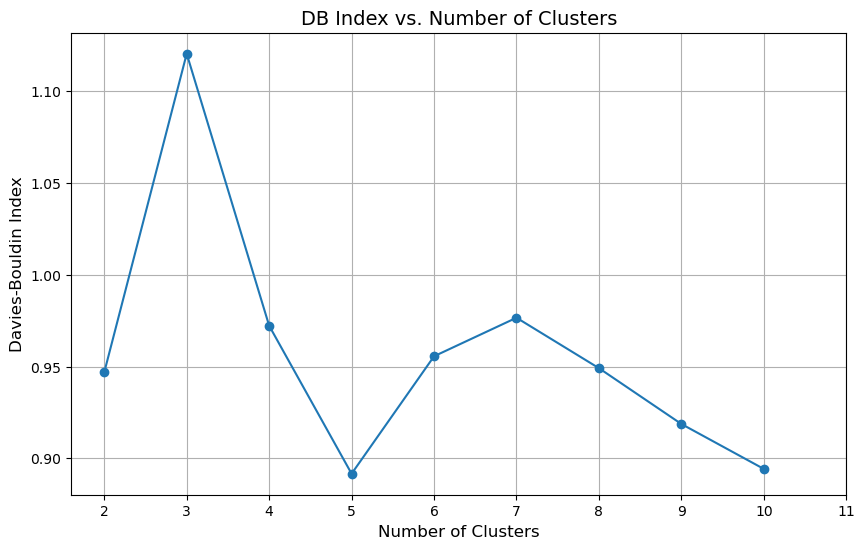

In [7]:
# Plotting the DB Index vs. n_clusters
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_clusters'], results_df['db_index'], marker='o', linestyle='-')
plt.title('DB Index vs. Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Davies-Bouldin Index', fontsize=12)
plt.xticks(range(2, 12))
plt.grid()
plt.show()


In [9]:
best_n_clusters

5

In [8]:
# Display the results DataFrame
print("DB Index Results:")
print(results_df)

# Train the final K-Means model using the best number of clusters
final_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
final_clusters = final_kmeans.fit_predict(clustering_data)

# Add cluster labels to the final dataset for visualization
final_features['Cluster'] = final_clusters

# Display the final features with cluster assignments
print("Final Features with Cluster Assignments:")
print(final_features.head())

DB Index Results:
   n_clusters  db_index
0           2  0.946879
1           3  1.120347
2           4  0.972245
3           5  0.891647
4           6  0.955597
5           7  0.976583
6           8  0.949121
7           9  0.918728
8          10  0.894258
Final Features with Cluster Assignments:
  CustomerID         Region  TotalTransactions  TotalQuantity  TotalSpend  \
0      C0001  South America          -0.011458      -0.122033   -0.061701   
1      C0002           Asia          -0.467494      -0.448000   -0.877744   
2      C0003  South America          -0.467494       0.203934   -0.405857   
3      C0004  South America           1.356650       1.670787    1.032547   
4      C0005           Asia          -0.923530      -0.936951   -0.783929   

   AvgSpendPerTransaction  Cluster  
0               -0.070263        0  
1               -0.934933        0  
2               -0.026271        0  
3               -0.076769        4  
4               -0.040028        3  


In [10]:
final_features.head(10)

,CustomerID,Region,TotalTransactions,TotalQuantity,TotalSpend,AvgSpendPerTransaction,Cluster
0,C0001,South America,-0.011458,-0.122033,-0.061701,-0.070263,0
1,C0002,Asia,-0.467494,-0.448000,-0.877744,-0.934933,0
2,C0003,South America,-0.467494,0.203934,-0.405857,-0.026271,0
3,C0004,South America,1.356650,1.670787,1.032547,-0.076769,4
4,C0005,Asia,-0.923530,-0.936951,-0.783929,-0.040028,3
5,C0006,South America,-0.467494,-0.122033,0.415879,1.556060,2
6,C0007,Asia,-0.923530,-0.773967,-0.485482,0.726221,3
7,C0008,North America,2.268722,1.181836,0.439970,-1.097250,4
8,C0009,Europe,-0.923530,-1.588886,-1.406302,-1.637946,1
9,C0010,Europe,-0.467494,-0.122033,-0.957166,-1.087869,0


In [11]:
final_features['Cluster'].unique()

array([0, 4, 3, 2, 1])

# Visualization step

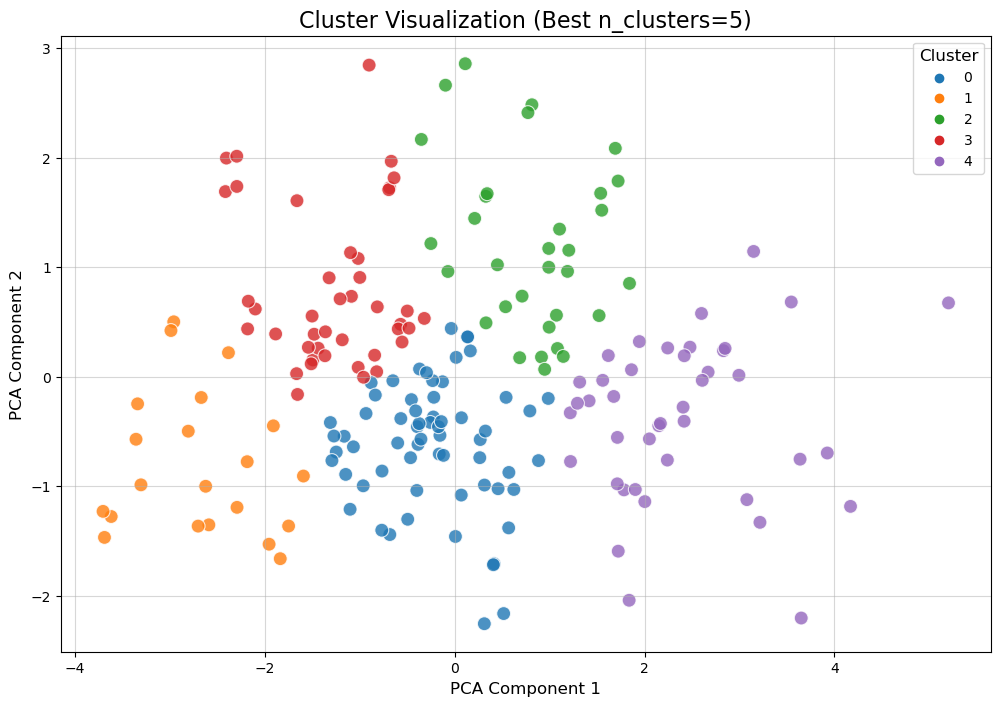

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reducing dimensions to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(clustering_data)

# Creating a DataFrame for visualization
visualization_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
visualization_df['Cluster'] = final_features['Cluster']

# Plotting the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=visualization_df, 
    x='PCA1', y='PCA2', 
    hue='Cluster', 
    palette='tab10', 
    s=100, 
    alpha=0.8
)
plt.title(f'Cluster Visualization (Best n_clusters={best_n_clusters})', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster', fontsize=10, title_fontsize=12)
plt.grid(alpha=0.5)
plt.show()


In [13]:
region_distribution = final_features.groupby(['Cluster', 'Region']).size().unstack()
print("Region Distribution by Cluster:")
print(region_distribution)


Region Distribution by Cluster:
Region   Asia  Europe  North America  South America
Cluster                                            
0           9      13             20             21
1           3       6              4              8
2           4      13              5             10
3          15      12              9              6
4          13       6              8             14


# Cluster Profiling and Insights

In [15]:
# Grouping by cluster and calculating summary statistics for numerical features
cluster_summary = final_features.groupby('Cluster').mean()

cluster_summary_rounded = cluster_summary[['TotalTransactions', 'TotalQuantity', 'TotalSpend', 'AvgSpendPerTransaction']].round(2)

print("Cluster Summary Statistics:")
print(cluster_summary_rounded)

# Analyzing region distribution within each cluster
region_distribution = final_features.groupby(['Cluster', 'Region']).size().unstack(fill_value=0)

print("\nRegion Distribution by Cluster:")
print(region_distribution)

# Adding percentages for region distribution
region_distribution_percentage = region_distribution.div(region_distribution.sum(axis=1), axis=0) * 100
region_distribution_percentage = region_distribution_percentage.round(2)

print("\nRegion Distribution Percentages by Cluster:")
print(region_distribution_percentage)


Cluster Summary Statistics:
         TotalTransactions  TotalQuantity  TotalSpend  AvgSpendPerTransaction
Cluster                                                                      
0                     0.20          -0.05       -0.28                   -0.57
1                    -1.23          -1.39       -1.48                   -1.51
2                    -0.07           0.23        0.67                    1.26
3                    -0.97          -0.83       -0.69                    0.40
4                     1.37           1.46        1.36                    0.26

Region Distribution by Cluster:
Region   Asia  Europe  North America  South America
Cluster                                            
0           9      13             20             21
1           3       6              4              8
2           4      13              5             10
3          15      12              9              6
4          13       6              8             14

Region Distribution Percenta